#### Mount Google Drive, Link to folder & install requirements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6756"
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

#### Imports

In [3]:
%matplotlib inline
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from utils import to_device, train_val_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.model_selection import train_test_split

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

#### Data

In [4]:
# Load data (numpy arrays)
train = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train.csv', index_col=0).values
val = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/val.csv', index_col=0).values
test = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test.csv', index_col=0).values

# Tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
val_tensor = torch.tensor(val, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

#### Arguments

In [5]:
@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 5  
  hidden: Tuple[int, ...] = (9, 7)

  # Optimization
  lr: float = 1e-3
  epochs: int = 100 

  # Miscellaneous
  device: str = 'cpu'


#### Model

In [6]:
class Encoder(nn.Module):

  def __init__(self, args):
    super(Encoder, self).__init__()

    self.input_dim = args.input_dim
    self.latent_dim = args.latent_dim
    self.hidden = args.hidden

    # Layers 
    self.input_layer = nn.Linear(self.input_dim, self.hidden[0])
    self.layers = nn.ModuleList()
    for i in range(1, len(self.hidden)):
      self.layers.append(nn.Linear(self.hidden[i-1], self.hidden[i]))
    self.output_layer = nn.Linear(self.hidden[-1], self.latent_dim)

    # Activations
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.relu(x)
    for layer in self.layers:
      x = layer(x)
      x = self.relu(x)
    x = self.output_layer(x)
    x = self.tanh(x)
    return x


class Decoder(nn.Module):

  def __init__(self, args):
    super(Decoder, self).__init__()

    self.input_dim = args.input_dim
    self.latent_dim = args.latent_dim
    self.hidden = args.hidden

    # Layers
    self.input_layer =  nn.Linear(self.latent_dim, self.hidden[-1])
    self.layers = nn.ModuleList()
    for i in range(len(self.hidden)-1, 0, -1):
      self.layers.append(nn.Linear(self.hidden[i], self.hidden[i-1]))
    self.output_layer = nn.Linear(self.hidden[0], self.input_dim)

    # Activations
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.input_layer(x)
    x = self.relu(x)
    for layer in self.layers:
      x = layer(x)
      x = self.relu(x)
    x = self.output_layer(x)
    x = self.relu(x)
    return x


class AE(nn.Module):

  def __init__(self, args):
    super(AE, self).__init__()

    self.input_dim = args.input_dim
    self.latent_dim = args.latent_dim
    self.hidden = args.hidden

    self.device = args.device

    self.encoder = Encoder(args).to(self.device)
    self.decoder = Decoder(args).to(self.device)

    self.criterion = nn.MSELoss(reduction="sum")

    self.logs = {"train loss": [], "val loss": []}

  def forward(self, x):
    return self.decoder(self.encoder(x))


#### Training loop

In [7]:
def train_ae(model, train_loader, val_loader, optimizer, args):

  # Init
  train_size = len(train_loader.dataset)
  val_size = len(val_loader.dataset)

  for epoch in range(args.epochs):

    running_loss = 0
    running_val_loss = 0

    for idx, batch in enumerate(train_loader):
      # Prediction
      target = to_device(batch, args.device)
      reconstruction = model(target)

      # Loss
      optimizer.zero_grad()
      loss = model.criterion(reconstruction, target)
      running_loss += loss.item()

      # Backprop and params' update 
      loss.backward()
      optimizer.step()

    for idx, batch in enumerate(val_loader):
      # Prediction
      target = to_device(batch, args.device)
      reconstruction = model(target)

      # Loss
      loss = model.criterion(reconstruction, target)
      running_val_loss += loss.item()
    
    # Average loss over the batches during the training
    model.logs["train loss"].append(running_loss/train_size)
    model.logs["val loss"].append(running_val_loss/train_size)

#### Execution

In [8]:
# Arguments
args = Arguments_ae(input_dim=9, 
                    latent_dim=8, 
                    hidden=(9,),
                    lr=1e-3,
                    epochs=25,
                    batch_size=16,
                    device="cuda")

In [9]:
# Model
autoencoder = AE(args)
print(autoencoder)
# Optimizer
adam = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)

AE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=9, out_features=9, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=9, out_features=8, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=8, out_features=9, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=9, out_features=9, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


In [10]:
# DataLoaders
train_loader = DataLoader(train_tensor,
                          batch_size=args.batch_size,
                          shuffle=False)
val_loader = DataLoader(val_tensor,
                        batch_size=args.batch_size,
                        shuffle=False)

In [11]:
# Training
train_ae(model=autoencoder, 
         train_loader=train_loader, 
         val_loader=val_loader, 
         optimizer=adam,
         args=args)

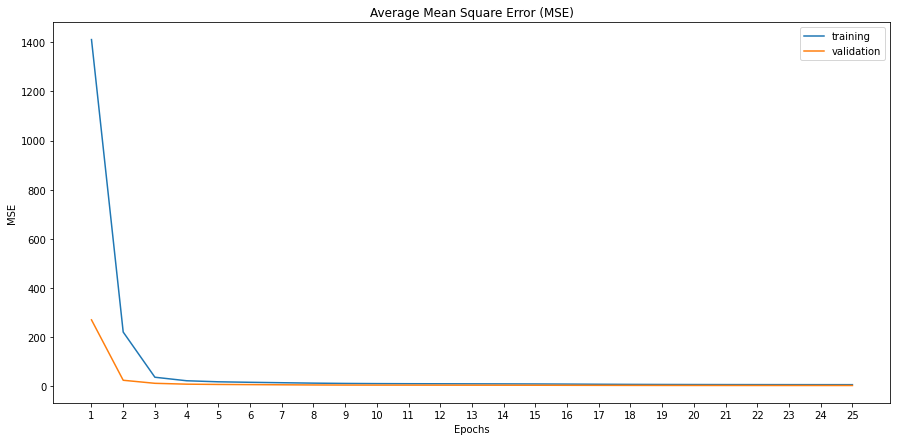

In [12]:
plt.figure(figsize=(15, 7))
plt.title("Average Mean Square Error (MSE)")
plt.plot(range(1, args.epochs+1), autoencoder.logs["train loss"], label="training")
plt.plot(range(1, args.epochs+1), autoencoder.logs["val loss"], label="validation")
plt.xticks(range(1, args.epochs+1))
plt.legend(loc=1)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

In [13]:
print("Validation examples")
for i in range(0, 10):
  examples = val_tensor[i].to(args.device)
  print('\n')
  print(f"Target: {examples}")
  print(f"Encoding: {autoencoder.encoder(examples)}")
  print(f"Decoding: {autoencoder(examples)}")

Validation examples


Target: tensor([5., 5., 8., 1., 0., 2., 3., 3., 1.], device='cuda:0')
Encoding: tensor([ 0.3387, -0.9722, -0.1864,  0.9714,  0.9943, -0.0722,  0.6986,  0.5154],
       device='cuda:0', grad_fn=<TanhBackward>)
Decoding: tensor([4.9861, 4.8004, 8.3496, 1.0916, 0.0000, 1.4686, 3.3349, 2.0174, 0.0000],
       device='cuda:0', grad_fn=<ReluBackward0>)


Target: tensor([ 4.,  3., 62.,  1.,  1.,  2.,  4.,  4.,  1.], device='cuda:0')
Encoding: tensor([ 0.0340, -0.4572, -0.9458,  0.9948,  0.9970, -0.6388, -0.2534, -0.4666],
       device='cuda:0', grad_fn=<TanhBackward>)
Decoding: tensor([ 4.6189,  2.6220, 62.2436,  1.2304,  1.0585,  1.4287,  2.9210,  3.5830,
         0.0000], device='cuda:0', grad_fn=<ReluBackward0>)


Target: tensor([ 5.,  5., 52.,  6.,  6.,  2.,  2.,  2.,  1.], device='cuda:0')
Encoding: tensor([-0.5696, -0.5765, -0.8478,  0.9889,  0.9917,  0.1594,  0.0533, -0.6316],
       device='cuda:0', grad_fn=<TanhBackward>)
Decoding: tensor([ 4.4967,  4.7812, 52.